## Load the necessary libariary and data

In [747]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import scipy.stats as stats
import seaborn as sns
import pickle

from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


warnings.filterwarnings('ignore', category=FutureWarning)

train = pd.read_csv('./data/train.csv')
train_labels = train[['regression target', 'classification target']]
train = train.drop(['regression target', 'classification target'], axis=1)
test = pd.read_csv('./data/test.csv')


#### Tuning Variables:

In [748]:
running_index = -1 # -1 for tuning and testing 

n_index = 0
c_index = 0
f_index = 0
fe_index = 0
n_pca = 15

if running_index == -1:
    n_index = 0
    c_index = 2
    f_index = 0
    fe_index = 1
    n_pca = 5

if running_index == 0:
    n_index = 1
    c_index = 1
    fe_index = 1

elif running_index == 1:
    n_index = 1
    c_index = 1
    fe_index = 1

elif running_index == 2:
    n_index = 1
    c_index = 2
    fe_index = 1

elif running_index == 3:
    n_index = 2
    c_index = 1
    fe_index = 1

elif running_index == 4:
    n_index = 2
    c_index = 2
    fe_index = 1

elif running_index == 5:
    n_index = 1
    c_index = 2
    f_index = 2
    fe_index = 1

elif running_index == 6:
    n_index = 1
    c_index = 2
    fe_index = 1

elif running_index == 7:
    c_index = 2


## Part 2:  Data Preprocessing Techniques

### [Q7] Handling Missing Values: 

In [749]:
imputer = SimpleImputer(strategy='mean')

numeric_data = train.select_dtypes(include=[np.number])
numeric_data_imputed = imputer.fit_transform(numeric_data)

train[numeric_data.columns] = numeric_data_imputed

### [Q8] Normalization and Standardization:

In [750]:
scaler_SS = StandardScaler()
scaler_MM = MinMaxScaler()
scaler_RS = RobustScaler()

train_SS = train.copy()
train_MM = train.copy()
train_RS = train.copy()

train_SS[numeric_data.columns] = scaler_SS.fit_transform(numeric_data_imputed)
train_MM[numeric_data.columns] = scaler_MM.fit_transform(numeric_data_imputed)
train_RS[numeric_data.columns] = scaler_RS.fit_transform(numeric_data_imputed)

first_numeric_column_index = 0
for i in range(len(train.columns)):
    column_name = train.columns[i]
    if train[column_name].dtype != 'object':
        first_numeric_column_index = i
        break

print('Original: ')
print(train.iloc[:, first_numeric_column_index].head(10))
print('Standard Scaler: ')
print(train_SS.iloc[:, first_numeric_column_index].head(10))
print('MinMax Scaler: ')
print(train_MM.iloc[:, first_numeric_column_index].head(10))
print('Robust Scaler: ')
print(train_RS.iloc[:, first_numeric_column_index].head(10))

Original: 
0    65.00
1    65.00
2    59.50
3    66.55
4    71.00
5    70.00
6    57.50
7    65.50
8    70.00
9    80.00
Name: C6, dtype: float64
Standard Scaler: 
0   -0.200135
1   -0.200135
2   -1.031074
3    0.034039
4    0.706344
5    0.555264
6   -1.333234
7   -0.124595
8    0.555264
9    2.066063
Name: C6, dtype: float64
MinMax Scaler: 
0    0.368421
1    0.368421
2    0.252632
3    0.401053
4    0.494737
5    0.473684
6    0.210526
7    0.378947
8    0.473684
9    0.684211
Name: C6, dtype: float64
Robust Scaler: 
0   -0.206667
1   -0.206667
2   -0.940000
3    0.000000
4    0.593333
5    0.460000
6   -1.206667
7   -0.140000
8    0.460000
9    1.793333
Name: C6, dtype: float64


### [Q9] Encoding Categorical Variables:

In [751]:
# using OneHotEncoder and OrdinalEncoder to encode the categorical data

encoder_OHE = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder_OE = OrdinalEncoder()

categorical_data = train[train.columns.difference(numeric_data.columns)]

categorical_data_encoded_OHE = pd.DataFrame()

for column in categorical_data.columns:
    encoded_column = encoder_OHE.fit_transform(categorical_data[[column]])
    column_names = [f"{column}_{category}" for category in encoder_OHE.categories_[0]]
    encoded_column = pd.DataFrame(encoded_column, columns=column_names)
    categorical_data_encoded_OHE = pd.concat([categorical_data_encoded_OHE, encoded_column], axis=1)
    
categorical_data_encoded_OE = pd.DataFrame(encoder_OE.fit_transform(categorical_data), columns=categorical_data.columns)

print('Original: ')
print(categorical_data.iloc[:10, 0])

print('OneHotEncoder: ')
print(categorical_data_encoded_OHE.iloc[:10, 0:7])

print('OrdinalEncoder: ')
print(categorical_data_encoded_OE.iloc[:10, 0])

Original: 
0    divorced
1      single
2      single
3     married
4      single
5      single
6      single
7      single
8      single
9      single
Name: C0, dtype: object
OneHotEncoder: 
   C0_divorced  C0_facto union  C0_legally separated  C0_married  C0_single  \
0          1.0             0.0                   0.0         0.0        0.0   
1          0.0             0.0                   0.0         0.0        1.0   
2          0.0             0.0                   0.0         0.0        1.0   
3          0.0             0.0                   0.0         1.0        0.0   
4          0.0             0.0                   0.0         0.0        1.0   
5          0.0             0.0                   0.0         0.0        1.0   
6          0.0             0.0                   0.0         0.0        1.0   
7          0.0             0.0                   0.0         0.0        1.0   
8          0.0             0.0                   0.0         0.0        1.0   
9          0.0     

### [Q10] Feature Selection:

In [752]:
train_final = pd.DataFrame()

if n_index == 0:
    train_n = train.select_dtypes(include=[np.number])
elif n_index == 1:
    train_n = train_SS.select_dtypes(include=[np.number])
elif n_index == 2:
    train_n = train_MM.select_dtypes(include=[np.number])
else:
    train_n = train_RS.select_dtypes(include=[np.number])

if c_index == 0:
    train_c = categorical_data
elif c_index == 1:
    train_c = categorical_data_encoded_OHE
else:
    train_c = categorical_data_encoded_OE

train_final = pd.concat([train_n, train_c], axis=1)

# print(train_final.head(10))

# using VarianceThreshold or SelectKBest to select the features
selector_VT = VarianceThreshold(threshold=0.1)
selector_SKB = SelectKBest(k=15)

if f_index == 0:
    train_f = train_final
elif f_index == 1:
    train_f = selector_VT.fit_transform(train_final)
elif f_index == 2:
    train_f = imputer.fit_transform(train_final)
    train_f = selector_SKB.fit_transform(train_f, train_labels['regression target']) 
else:
    train_f = imputer.fit_transform(train_final)
    train_f = selector_SKB.fit_transform(train_f, train_labels['classification target'])



### [Q11] Feature Engineering: 

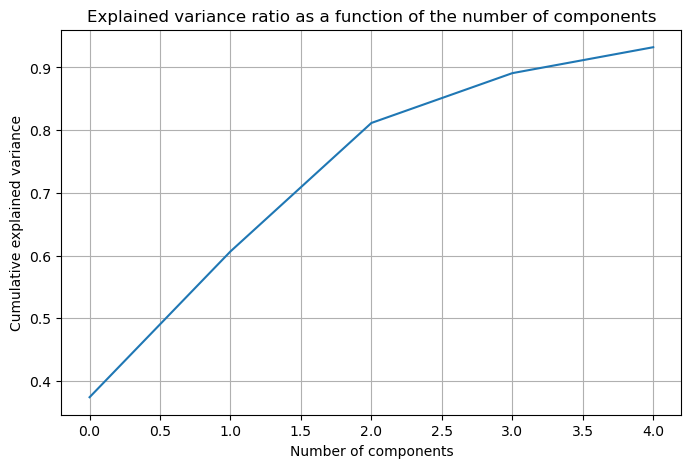

In [753]:
# using PCA, UMAP to reduce the dimensionality of the data
pca = PCA(n_components=n_pca)


if fe_index == 0:
    train_fe = train_f
elif fe_index == 1:
    train_fe = imputer.fit_transform(train_f)
    train_fe = pca.fit_transform(train_fe)
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.title('Explained variance ratio as a function of the number of components')
    plt.grid(True)
    plt.savefig('./pic/PCA.png')
    plt.show()
else:
    train_fe = umap.fit_transform(train_f)

## Part 3: Regression

In [754]:
np.random.seed(4211)
regressor = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(train_fe, train_labels['regression target'], test_size=0.2, random_state=4211)

### Step 1:

#### First model:

In [755]:
# use the PCA3 of OHE data to regress the regression target linearly 
if running_index == 0:
    x = X_train[:,2].reshape(-1, 1)  
    y = y_train.values 

    
    lm_1 = regressor.fit(x, y)

    print("Coefficient:", regressor.coef_)
    print("Intercept:", regressor.intercept_)
    print("R^2 score:", regressor.score(x, y))

    if not os.path.exists('./result/regression'):
        os.makedirs('./result/regression')
    with open('./result/regression/model1.txt', 'w') as f:
        f.write("Coefficient: " + str(regressor.coef_) + "\n")
        f.write("Intercept: " + str(regressor.intercept_) + "\n")
        f.write("R^2 score: " + str(regressor.score(x, y)) + "\n")
    with open('./result/regression/model1.pkl', 'wb') as f:
        pickle.dump(lm_1, f)
else:
    # print the result from the saved model
    with open('./result/regression/model1.txt', 'r') as f:
        print(f.read())

Coefficient: [0.00161621]
Intercept: 0.6347358742479619
R^2 score: 0.0008168019203941279



#### Second model:

In [756]:
# use the PCA7 of SS+OHE data to regress the regression target linearly 
if running_index == 1:
    x = X_train[:,6].reshape(-1, 1)  
    y = y_train.values 

    
    lm_2 = regressor.fit(x, y)

    print("Coefficient:", regressor.coef_)
    print("Intercept:", regressor.intercept_)
    print("R^2 score:", regressor.score(x, y))

    if not os.path.exists('./result/regression'):
        os.makedirs('./result/regression')
    with open('./result/regression/model2.txt', 'w') as f:
        f.write("Coefficient: " + str(regressor.coef_) + "\n")
        f.write("Intercept: " + str(regressor.intercept_) + "\n")
        f.write("R^2 score: " + str(regressor.score(x, y)) + "\n")
    with open('./result/regression/model2.pkl', 'wb') as f:
        pickle.dump(lm_2, f)
else:
    # print the result from the saved model
    with open('./result/regression/model2.txt', 'r') as f:
        print(f.read())

Coefficient: [0.02841736]
Intercept: 0.6338257462759013
R^2 score: 0.15039459943070976



#### Third model:

In [757]:
# use the PCA10 of SS+OE data to regress the regression target linearly
if running_index == 2:
    x = X_train[:,9].reshape(-1, 1)  
    y = y_train.values 

    
    lm_3 = regressor.fit(x, y)

    print("Coefficient:", regressor.coef_)
    print("Intercept:", regressor.intercept_)
    print("R^2 score:", regressor.score(x, y))

    if not os.path.exists('./result/regression'):
        os.makedirs('./result/regression')
    with open('./result/regression/model3.txt', 'w') as f:
        f.write("Coefficient: " + str(regressor.coef_) + "\n")
        f.write("Intercept: " + str(regressor.intercept_) + "\n")
        f.write("R^2 score: " + str(regressor.score(x, y)) + "\n")
    with open('./result/regression/model3.pkl', 'wb') as f:
        pickle.dump(lm_3, f)
else:
    # print the result from the saved model
    with open('./result/regression/model3.txt', 'r') as f:
        print(f.read())

Coefficient: [0.03860806]
Intercept: 0.6340257779380218
R^2 score: 0.2831168460970953



#### Forth model:

In [758]:
# use the PCA7 of MM+OHE data to regress the regression target linearly
if running_index == 3:
    x = X_train[:,6].reshape(-1, 1)  
    y = y_train.values 

    
    lm_4 = regressor.fit(x, y)

    print("Coefficient:", regressor.coef_)
    print("Intercept:", regressor.intercept_)
    print("R^2 score:", regressor.score(x, y))

    if not os.path.exists('./result/regression'):
        os.makedirs('./result/regression')
    with open('./result/regression/model4.txt', 'w') as f:
        f.write("Coefficient: " + str(regressor.coef_) + "\n")
        f.write("Intercept: " + str(regressor.intercept_) + "\n")
        f.write("R^2 score: " + str(regressor.score(x, y)) + "\n")
    with open('./result/regression/model4.pkl', 'wb') as f:
        pickle.dump(lm_4, f)
else:
    # print the result from the saved model
    with open('./result/regression/model4.txt', 'r') as f:
        print(f.read())

Coefficient: [-0.02890195]
Intercept: 0.6355380773926628
R^2 score: 0.039120989555041064



#### Fifth model:

In [759]:
# use the PCA3 of MM+OE data to regress the regression target linearly
if running_index == 4:
    x = X_train[:,2].reshape(-1, 1)  
    y = y_train.values 

    
    lm_5 = regressor.fit(x, y)

    print("Coefficient:", regressor.coef_)
    print("Intercept:", regressor.intercept_)
    print("R^2 score:", regressor.score(x, y))

    if not os.path.exists('./result/regression'):
        os.makedirs('./result/regression')
    with open('./result/regression/model5.txt', 'w') as f:
        f.write("Coefficient: " + str(regressor.coef_) + "\n")
        f.write("Intercept: " + str(regressor.intercept_) + "\n")
        f.write("R^2 score: " + str(regressor.score(x, y)) + "\n")
    with open('./result/regression/model5.pkl', 'wb') as f:
        pickle.dump(lm_5, f)
else:
    # print the result from the saved model
    with open('./result/regression/model5.txt', 'r') as f:
        print(f.read())

Coefficient: [-0.00237042]
Intercept: 0.6342637605892387
R^2 score: 0.005990838695393852



#### Sixth model:

In [760]:
# use the weighted sum of SS+OE+SKT data to regress the regression target linearly
if running_index == 5:
    weight = np.array([1,-1,1,-1,-1,1,1,1,-1,1,-1,-1,-1,-1,-1])
    x = np.dot(X_train, weight.reshape(-1, 1))  
    y = y_train.values 

    
    lm_6 = regressor.fit(x, y)

    print("Coefficient:", regressor.coef_)
    print("Intercept:", regressor.intercept_)
    print("R^2 score:", regressor.score(x, y))

    if not os.path.exists('./result/regression'):
        os.makedirs('./result/regression')
    with open('./result/regression/model6.txt', 'w') as f:
        f.write("Coefficient: " + str(regressor.coef_) + "\n")
        f.write("Intercept: " + str(regressor.intercept_) + "\n")
        f.write("R^2 score: " + str(regressor.score(x, y)) + "\n")
    with open('./result/regression/model6.pkl', 'wb') as f:
        pickle.dump(lm_6, f)
else:
    # print the result from the saved model
    with open('./result/regression/model6.txt', 'r') as f:
        print(f.read())

Coefficient: [0.00218796]
Intercept: 0.6337444430826301
R^2 score: 0.04664150224176111



### Step 2:

In [761]:
# use the PCA1 to 15 of SS+OE data to regress the regression target linearly
if running_index == 6:
    x = X_train
    y = y_train.values 

    lm_m = regressor.fit(x, y)

    print("Coefficient:", regressor.coef_)
    print("Intercept:", regressor.intercept_)
    print("R^2 score:", regressor.score(x, y))

    if not os.path.exists('./result/regression'):
        os.makedirs('./result/regression')
    with open('./result/regression/model7.txt', 'w') as f:
        f.write("Coefficient: " + str(regressor.coef_) + "\n")
        f.write("Intercept: " + str(regressor.intercept_) + "\n")
        f.write("R^2 score: " + str(regressor.score(x, y)) + "\n")

    with open('./result/regression/model7.pkl', 'wb') as f:
        pickle.dump(lm_m, f)
else:
    # print the result from the saved model
    with open('./result/regression/model7.txt', 'r') as f:
        print(f.read())

Coefficient: [ 0.0006543   0.00061896  0.00140559 -0.00304779 -0.00348586  0.00242793
 -0.0041325   0.00692544 -0.00692318  0.03848162  0.00453046  0.00124085
 -0.01051636  0.00355501 -0.00238613]
Intercept: 0.6346202190123388
R^2 score: 0.36606754095883587



### MSE for all model:

In [762]:
# compute all MSE for all models and save it 
i = running_index
if i == 0:
    with open('./result/regression/model1.pkl', 'rb') as f:
        lm = pickle.load(f)
        y_pred = lm.predict(X_test[:,2].reshape(-1, 1))
elif i == 1:
    with open('./result/regression/model2.pkl', 'rb') as f:
        lm = pickle.load(f)
        y_pred = lm.predict(X_test[:,6].reshape(-1, 1))
elif i == 2:
    with open('./result/regression/model3.pkl', 'rb') as f:
        lm = pickle.load(f)
        y_pred = lm.predict(X_test[:,9].reshape(-1, 1))
elif i == 3:
    with open('./result/regression/model4.pkl', 'rb') as f:
        lm = pickle.load(f)
        y_pred = lm.predict(X_test[:,6].reshape(-1, 1))
elif i == 4:
    with open('./result/regression/model5.pkl', 'rb') as f:
        lm = pickle.load(f)
        y_pred = lm.predict(X_test[:,2].reshape(-1, 1))
elif i == 5:
    with open('./result/regression/model6.pkl', 'rb') as f:
        lm = pickle.load(f)
        y_pred = lm.predict(np.dot(X_test, weight.reshape(-1, 1)))
elif i == 6:
    with open('./result/regression/model7.pkl', 'rb') as f:
        lm = pickle.load(f)
        y_pred = lm.predict(X_test)
if i <= 6 and i >= 0:
    mse = np.mean((y_pred - y_test.values) ** 2)
    print("MSE for model", i+1, ":", mse)
    with open('./result/regression/mse.txt', 'a') as f:
        f.write("MSE for model " + str(i+1) + ": " + str(mse) + "\n")


### Repeating Q12, Q13 using a categorical feature:

In [763]:
# use a categorical feature to regress the regression target linearly
if running_index == 7:
    X_train, X_test, y_train, y_test = train_test_split(imputer.fit_transform(train_c), train_labels['regression target'], test_size=0.2, random_state=running_index)
    
    using_index = 1

    x = X_train[:,using_index]
    x = x.reshape(-1, 1)
    y = y_train.values

    lm_8 = regressor.fit(x, y)

    print("Coefficient:", regressor.coef_)
    print("Intercept:", regressor.intercept_)
    print("R^2 score:", regressor.score(x, y))

    if not os.path.exists('./result/regression'):
        os.makedirs('./result/regression')
    with open('./result/regression/model8.txt', 'w') as f:
        f.write("Coefficient: " + str(regressor.coef_) + "\n")
        f.write("Intercept: " + str(regressor.intercept_) + "\n")
        f.write("R^2 score: " + str(regressor.score(x, y)) + "\n")
    with open('./result/regression/model8.pkl', 'wb') as f:
        pickle.dump(lm_8, f)
else:
    # print the result from the saved model
    with open('./result/regression/model8.txt', 'r') as f:
        print(f.read())

# compute all MSE for all models and save it
i = running_index
if i == 7:
    with open('./result/regression/model8.pkl', 'rb') as f:
        lm = pickle.load(f)
        y_pred = lm.predict(X_test[:,using_index].reshape(-1, 1))

    mse = np.mean((y_pred - y_test.values) ** 2)
    print("MSE for model", i+1, ":", mse)
    with open('./result/regression/mse.txt', 'a') as f:
        f.write("MSE for model " + str(i+1) + ": " + str(mse) + "\n")


Coefficient: [0.00066172]
Intercept: 0.6306473281433052
R^2 score: 0.0029046875364202585

